# Fastai Classification - Device Manufacturer
This notebook features an example of training a classification model to determine the device manufacturer based on the photos of the chest X-ray images as well as device manufacturer information given as a column `Hersteller` in the metadata spreadsheet. As inputs, the model uses 256x256 crops of the original images containing the pacemaker/biomonitor device. Crops were generated using the segmentation pipeline.

In [1]:
import torch
import pandas as pd
from fastai.vision.all import *
import os
import numpy as np
import json
import sklearn
import pickle
from pathlib import Path

import warnings

warnings.filterwarnings("ignore")

Setting the paths to the `Dataset` folder containing the images. Relative path is defined to keep the style consistent with that of the segmentation pipeline. 

In [2]:
# Defining paths to the dataset
abs_dataset_path = Path("/workdir/cied/Dataset")
rel_dataset_path = Path(os.path.relpath(abs_dataset_path))

In [3]:
# Loading the metadata spreadsheet
# Loading the metadata spreadsheet
df = pd.read_excel(abs_dataset_path / "04_train_data_clf.xlsx")

# Providing relative paths to the filenames for the dataloader
df.loc[:, "patch_fname"] = df.loc[:, "patch_fname"].apply(lambda x: str(rel_dataset_path / "Classification" / x))

In [4]:
# Setting the experiment name to save the model
exp_name = "s256_cls_h"

In [5]:
# Initializing the dataloader
dls = ImageDataLoaders.from_df(
    df,
    fn_col="patch_fname",
    label_col="Hersteller",
    valid_col="is_valid",
    item_tfms=Resize(256),
    batch_tfms=[*aug_transforms(size=256, min_scale=0.1)],
    bs=256,
)

In [6]:
# Setting the seeds for reproducibility purposes
set_seed(42, True)
dls.rng.seed(42)
# Initializing the learner
learner = vision_learner(dls, resnet50, metrics=accuracy).to_fp16()

In [7]:
# Training the model
learner.fit_one_cycle(80)

epoch,train_loss,valid_loss,accuracy,time
0,2.393331,1.661076,0.362525,00:31
1,2.219506,1.584485,0.419552,00:25
2,2.011996,1.424791,0.522743,00:25
3,1.795993,1.164327,0.633401,00:26
4,1.582017,1.020670,0.675492,00:25
5,1.316395,0.875842,0.727766,00:25
6,1.166747,0.832543,0.728445,00:26
7,0.984103,0.697270,0.775289,00:25
8,0.843602,0.518758,0.817379,00:25
9,0.714935,0.408643,0.854039,00:25


The model achieves an overall accuracy of 0.96 on the validation dataset.

In [8]:
# Saving the model
save_model("models/{}".format(exp_name), learner.model, learner.opt)

## Estimating performance on test data, visualizing results

In [9]:
# Reading holdout dataframe
holdout_df = pd.read_excel(abs_dataset_path / "03_holdout_data_clf.xlsx")

# Providing relative paths to the filenames for the dataloader
holdout_df.loc[:, "patch_fname"] = holdout_df.loc[:, "patch_fname"].apply(
    lambda x: str(rel_dataset_path / "Classification" / x)
)

In [10]:
# Replacing validation data with holdout (test) data in the dataloader
holdout_df = pd.concat([df[~df["is_valid"]], holdout_df])

In [11]:
# Initializing dataloader for testing
dls = ImageDataLoaders.from_df(
    holdout_df,
    fn_col="patch_fname",
    label_col="Hersteller",
    valid_col="is_valid",
    item_tfms=Resize(256),
    batch_tfms=[*aug_transforms(size=256, min_scale=0.1)],
    bs=16,
)

In [12]:
# Loading the model
learner = vision_learner(dls, resnet50, metrics=accuracy).to_fp16()
load_model("models/{}".format(exp_name), learner.model, learner.opt, device="cuda:0")

In [13]:
# Validating the model
res = learner.validate()
print(f"Test accuracy: {res[1]:.3}")

Test accuracy: 0.945


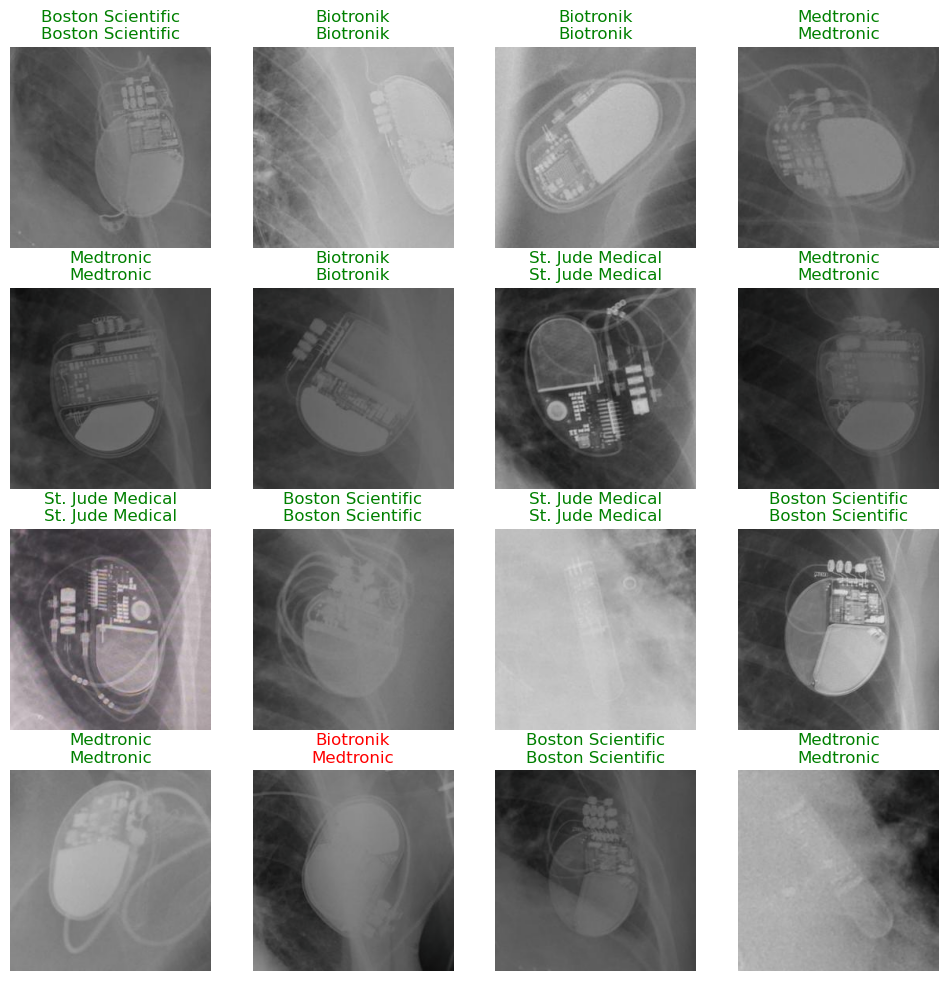

In [14]:
# Visualizing results: True label above, Prediction below
learner.show_results(max_n=16)

## Retrieving confidence intervals

In [15]:
res = learner.get_preds()

holdout_df = pd.read_excel(abs_dataset_path / "03_holdout_data_clf.xlsx")

probs = np.array(res[0])
targs = np.array(res[1])

preds = np.argmax(probs, axis=1)

output_df = pd.DataFrame(data=probs, columns=learner.dls[1].vocab)

output_df.columns = [str(i) + " - " + output_df.columns[i] for i in range(len(output_df.columns))]

output_df.loc[:, "Prediction"] = preds

output_df.loc[:, "Target"] = targs

output_df.index = holdout_df["patch_fname"]

output_df.to_excel(abs_dataset_path / "05c_preds_confidence_manufacturer.xlsx")